In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d alihasnainch/fruits-dataset-for-classification

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/alihasnainch/fruits-dataset-for-classification
License(s): apache-2.0
fruits-dataset-for-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip fruits-dataset-for-classification.zip

Archive:  fruits-dataset-for-classification.zip
  inflating: fresh_peaches_done/fresh_peach_1.jpg  
  inflating: fresh_peaches_done/fresh_peach_10.jpg  
  inflating: fresh_peaches_done/fresh_peach_100.jpg  
  inflating: fresh_peaches_done/fresh_peach_101.jpg  
  inflating: fresh_peaches_done/fresh_peach_102.jpg  
  inflating: fresh_peaches_done/fresh_peach_103.jpg  
  inflating: fresh_peaches_done/fresh_peach_104.jpg  
  inflating: fresh_peaches_done/fresh_peach_105.jpg  
  inflating: fresh_peaches_done/fresh_peach_106.jpg  
  inflating: fresh_peaches_done/fresh_peach_107.jpg  
  inflating: fresh_peaches_done/fresh_peach_108.jpg  
  inflating: fresh_peaches_done/fresh_peach_109.jpg  
  inflating: fresh_peaches_done/fresh_peach_11.jpg  
  inflating: fresh_peaches_done/fresh_peach_110.jpg  
  inflating: fresh_peaches_done/fresh_peach_111.jpg  
  inflating: fresh_peaches_done/fresh_peach_112.jpg  
  inflating: fresh_peaches_done/fresh_peach_113.jpg  
  inflating: fresh_peaches_done/fresh_

#Libraries


In [ ]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import seaborn as sns

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras.layers import Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from keras.layers import Input
from keras import layers

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array
from PIL import Image

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2024-08-15 16:27:20--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2024-08-15 16:27:21 (9.35 MB/s) - ‘helper_functions.py’ saved [10246/10246]



# 📥Load and Transform Data

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = (300, 300)

In [ ]:
# Walk through each directory
dataset = "/content/archive"
walk_through_dir(dataset)

There are 6 directories and 0 images in '/content/archive'.
There are 0 directories and 250 images in '/content/archive/rotten_pomegranates_done'.
There are 0 directories and 343 images in '/content/archive/rotten_peaches_done'.
There are 0 directories and 251 images in '/content/archive/rotten_strawberries_done'.
There are 0 directories and 250 images in '/content/archive/fresh_strawberries_done'.
There are 0 directories and 311 images in '/content/archive/fresh_pomegranates_done'.
There are 0 directories and 250 images in '/content/archive/fresh_peaches_done'.


#📅Placing data into a Dataframe
The first column filepaths contains the file path location of each individual images. The second column labels, on the other hand, contains the class label of the corresponding image from the file path

In [ ]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.*'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [ ]:
image_df

Filepath  \
0     /content/archive/rotten_pomegranates_done/rott...   
1     /content/archive/rotten_pomegranates_done/rott...   
2     /content/archive/rotten_pomegranates_done/rott...   
3     /content/archive/rotten_pomegranates_done/rott...   
4     /content/archive/rotten_pomegranates_done/rott...   
...                                                 ...   
1650  /content/archive/fresh_peaches_done/fresh_peac...   
1651  /content/archive/fresh_peaches_done/fresh_peac...   
1652  /content/archive/fresh_peaches_done/fresh_peac...   
1653  /content/archive/fresh_peaches_done/fresh_peac...   
1654  /content/archive/fresh_peaches_done/fresh_peac...   

                         Label  
0     rotten_pomegranates_done  
1     rotten_pomegranates_done  
2     rotten_pomegranates_done  
3     rotten_pomegranates_done  
4     rotten_pomegranates_done  
...                        ...  
1650        fresh_peaches_done  
1651        fresh_peaches_done  
1652        fresh_peaches_done  
1653        fresh_peaches_done  
1654        fresh_peaches_done  

[1655 rows x 2 columns]

# 🔭Visualizing images from the dataset

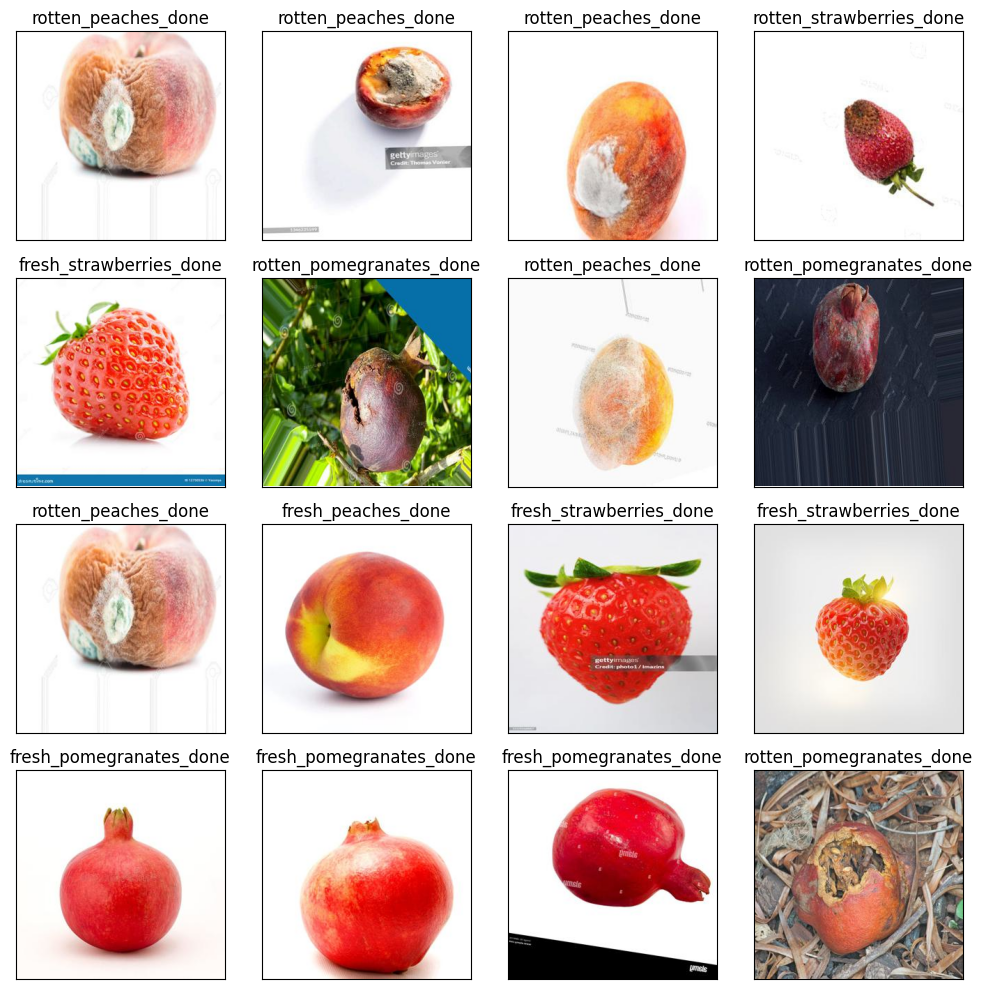

In [ ]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

# 📝Data Preprocessing
The data will be split into three different categories: Training, Validation and Testing. The training data will be used to train the deep learning CNN model and its parameters will be fine tuned with the validation data. Finally, the performance of the data will be evaluated using the test data(data the model has not previously seen).

In [ ]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 1060 validated image filenames belonging to 6 classes.
Found 264 validated image filenames belonging to 6 classes.
Found 331 validated image filenames belonging to 6 classes.


In [ ]:
print(val_images.filepaths)  # Should not be 0


['/content/archive/fresh_pomegranates_done/fresh_pomegranate_13.jpg', '/content/archive/rotten_peaches_done/rotten_peach_233.jpg', '/content/archive/rotten_pomegranates_done/rotten_pomegranate_109.jpg', '/content/archive/rotten_peaches_done/rotten_peach_201.jpg', '/content/archive/fresh_strawberries_done/fresh_strawberry_244.jpg', '/content/archive/rotten_pomegranates_done/rotten_pomegranate_38.jpg', '/content/archive/rotten_strawberries_done/rotten_strawberry_234.jpg', '/content/archive/fresh_peaches_done/fresh_peach_196.jpg', '/content/archive/fresh_pomegranates_done/fresh_pomegranate_48.jpg', '/content/archive/fresh_pomegranates_done/fresh_pomegranate_168.jpg', '/content/archive/fresh_pomegranates_done/fresh_pomegranate_289.jpg', '/content/archive/rotten_strawberries_done/rotten_strawberry_52.jpg', '/content/archive/fresh_strawberries_done/fresh_strawberry_224.jpg', '/content/archive/fresh_strawberries_done/fresh_strawberry_55.jpg', '/content/archive/fresh_pomegranates_done/fresh_po

In [ ]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(224,224),
  layers.Rescaling(1./255),
])

# 🤹Training the model
The model images will be subjected to a pre-trained CNN model called MobileNetV2. Three callbacks will be utilized to monitor the training. These are: Model Checkpoint, Early Stopping, Tensorboard callback. The summary of the model hyperparameter is shown as follows:

**Batch size** : 32

**Epochs** : 100

**Input Shape** : (300, 300, 3)

**Output layer** : 5



In [ ]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# Create checkpoint callback
checkpoint_path = "fruit_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

# 🚄Training the model

In [ ]:


inputs = pretrained_model.input
x = resize_and_rescale(inputs)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)


outputs = Dense(6, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=20,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "fruit_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/fruit_classification/20240815-165928
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 346ms/step - accuracy: 0.3067 - loss: 1.7360 - val_accuracy: 0.7348 - val_loss: 1.1136
Epoch 2/20


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


AttributeError: 'NoneType' object has no attribute 'items'

# ✔️Model Evaluation
The test dataset will be used to evaluate the performance of the model.One of the metrics that will be tested would be accuracy which measures the fraction of predictions the model got right. Other metrics are as follows:

**Precision(P)**:
The fraction of true positives (TP, correct predictions) from the total amount of relevant results, i.e., the sum of TP and false positives (FP). For multi-class classification problems, P is averaged among the classes. The following is the formula for precision.

<center>$P=TP/(TP+FP)$</center>

**Recall(R)**:
The fraction of TP from the total amount of TP and false negatives (FN). For multi-class classification problems, R gets averaged among all the classes. The following is the formula for recall.
<center>$R=TP/(TP+FN)$</center>

**F1 score(F1)**:
The harmonic mean of precision and recall. For multi-class classification problems, F1 gets averaged among all the classes. The following is the formula for F1 score.
<center>$F1=2 * (TP * FP)/(TP+FP)$</center>



In [ ]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.26853
Test Accuracy: 90.33%


# 📉Visualizing loss curves

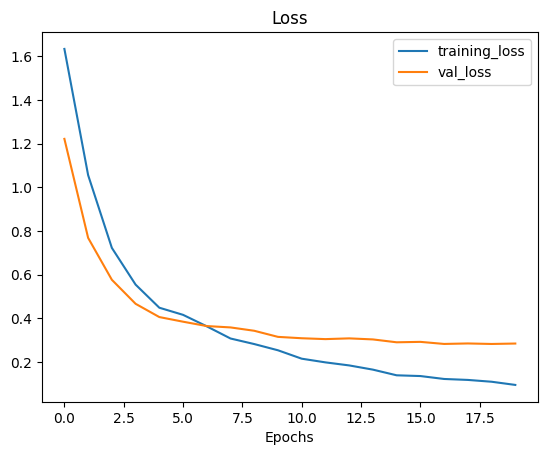

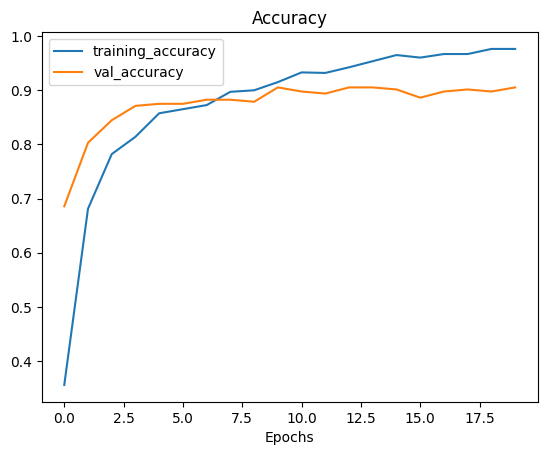

In [ ]:
plot_loss_curves(history)

# 🔮Making predictions on the Test Data

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

11/11 [==============================] - 1s 58ms/step
The first 5 predictions: ['rotten_strawberries_done', 'fresh_strawberries_done', 'rotten_peaches_done', 'fresh_peaches_done', 'fresh_strawberries_done']


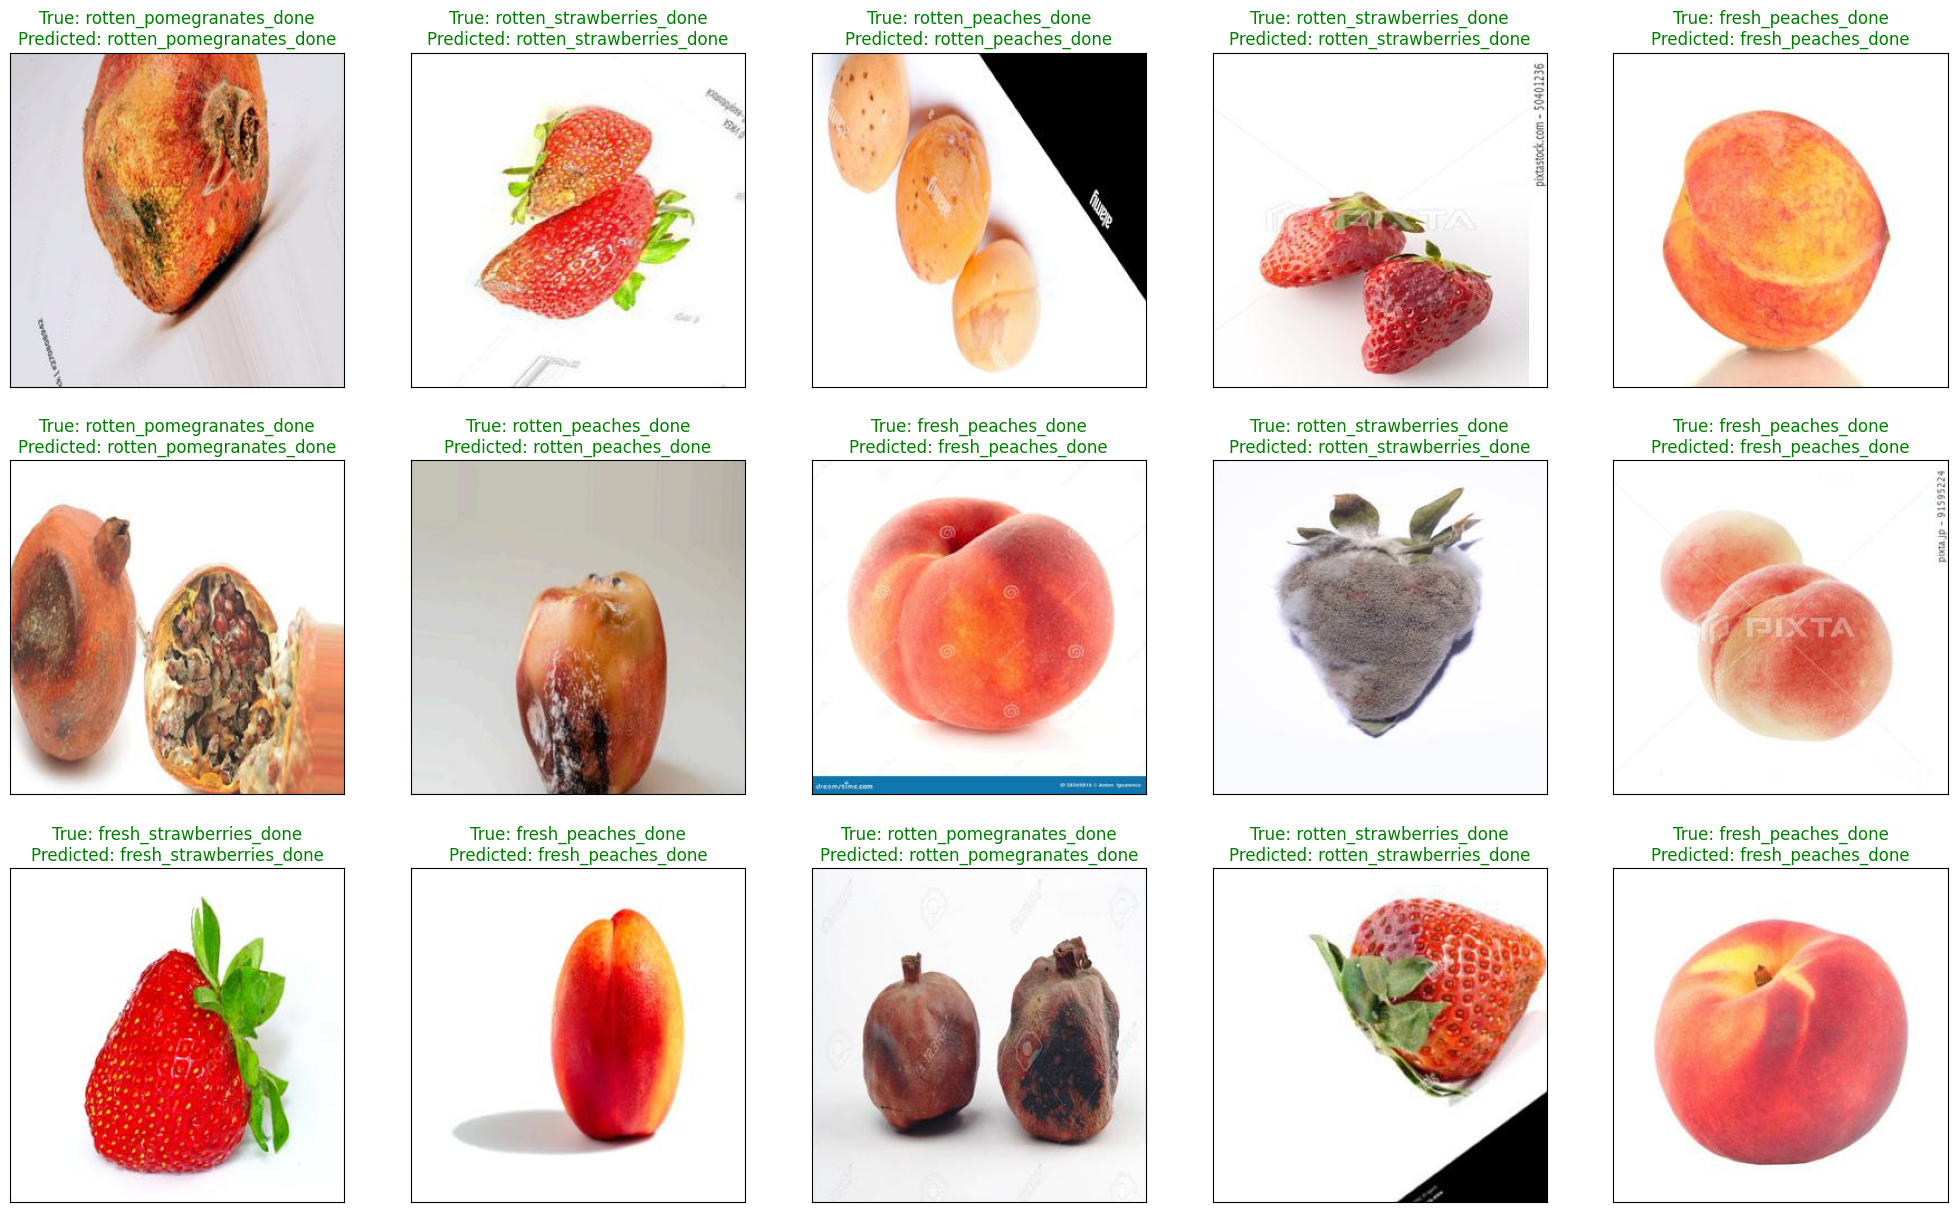

<Figure size 640x480 with 0 Axes>

In [ ]:
  # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

# 📊Plotting the Classification Reports and Confusion Matrix

In [ ]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                          precision    recall  f1-score   support

      fresh_peaches_done       0.98      0.94      0.96        49
 fresh_pomegranates_done       0.93      0.96      0.95        56
 fresh_strawberries_done       0.88      0.96      0.92        51
     rotten_peaches_done       0.87      0.90      0.88        80
rotten_pomegranates_done       0.82      0.76      0.79        42
rotten_strawberries_done       0.96      0.87      0.91        53

                accuracy                           0.90       331
               macro avg       0.91      0.90      0.90       331
            weighted avg       0.90      0.90      0.90       331



In [ ]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score     support
fresh_peaches_done         0.978723  0.938776  0.958333   49.000000
fresh_pomegranates_done    0.931034  0.964286  0.947368   56.000000
fresh_strawberries_done    0.875000  0.960784  0.915888   51.000000
rotten_peaches_done        0.867470  0.900000  0.883436   80.000000
rotten_pomegranates_done   0.820513  0.761905  0.790123   42.000000
rotten_strawberries_done   0.958333  0.867925  0.910891   53.000000
accuracy                   0.903323  0.903323  0.903323    0.903323
macro avg                  0.905179  0.898946  0.901007  331.000000
weighted avg               0.904445  0.903323  0.902896  331.000000

In [ ]:
cm = confusion_matrix(y_test, pred)

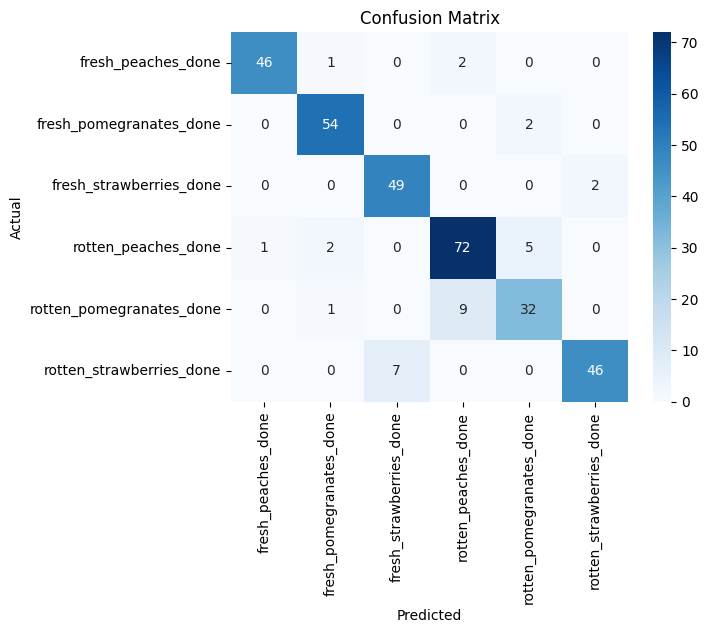

In [ ]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=labels.values(), yticklabels=labels.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
cm.shape

(6, 6)

In [ ]:
model.save('fruit_classification_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
test_outside = "/content/test outside"
walk_through_dir(test_outside)

There are 7 directories and 0 images in '/content/test outside'.
There are 0 directories and 0 images in '/content/test outside/.ipynb_checkpoints'.
There are 0 directories and 2 images in '/content/test outside/fresh_strawberries_done'.
There are 1 directories and 2 images in '/content/test outside/rotten_peaches_done'.
There are 0 directories and 0 images in '/content/test outside/rotten_peaches_done/.ipynb_checkpoints'.
There are 0 directories and 2 images in '/content/test outside/fresh_peaches_done'.
There are 1 directories and 2 images in '/content/test outside/rotten_strawberries_done'.
There are 0 directories and 0 images in '/content/test outside/rotten_strawberries_done/.ipynb_checkpoints'.
There are 0 directories and 2 images in '/content/test outside/fresh_pomegranates_done'.
There are 1 directories and 2 images in '/content/test outside/rotten_pomegranates_done'.
There are 0 directories and 0 images in '/content/test outside/rotten_pomegranates_done/.ipynb_checkpoints'.


In [ ]:
test_outside = Path(test_outside)
filepaths_test = list(test_outside.glob(r'**/*.*'))
labels_test = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths_test))
filepaths_test = pd.Series(filepaths_test, name='Filepath').astype(str)
labels_test = pd.Series(labels_test, name='Label')
image_df_test = pd.concat([filepaths_test, labels_test], axis=1)
image_df_test

Filepath  \
0            /content/test outside/.ipynb_checkpoints   
1   /content/test outside/fresh_strawberries_done/...   
2   /content/test outside/fresh_strawberries_done/...   
3   /content/test outside/rotten_peaches_done/peac...   
4   /content/test outside/rotten_peaches_done/.ipy...   
5   /content/test outside/rotten_peaches_done/peac...   
6   /content/test outside/fresh_peaches_done/peach...   
7   /content/test outside/fresh_peaches_done/peach...   
8   /content/test outside/rotten_strawberries_done...   
9   /content/test outside/rotten_strawberries_done...   
10  /content/test outside/rotten_strawberries_done...   
11  /content/test outside/fresh_pomegranates_done/...   
12  /content/test outside/fresh_pomegranates_done/...   
13  /content/test outside/rotten_pomegranates_done...   
14  /content/test outside/rotten_pomegranates_done...   
15  /content/test outside/rotten_pomegranates_done...   

                       Label  
0               test outside  
1    fresh_strawberries_done  
2    fresh_strawberries_done  
3        rotten_peaches_done  
4        rotten_peaches_done  
5        rotten_peaches_done  
6         fresh_peaches_done  
7         fresh_peaches_done  
8   rotten_strawberries_done  
9   rotten_strawberries_done  
10  rotten_strawberries_done  
11   fresh_pomegranates_done  
12   fresh_pomegranates_done  
13  rotten_pomegranates_done  
14  rotten_pomegranates_done  
15  rotten_pomegranates_done

In [ ]:
test_outside_generator = test_generator.flow_from_dataframe(
    dataframe=image_df_test,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 12 validated image filenames belonging to 6 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 4 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(


In [ ]:

# Predict the label of the test_images
pred2 = model.predict(test_outside_generator)
pred2 = np.argmax(pred2,axis=1)

# Map the label
labels2 = (train_images.class_indices)
labels2 = dict((v,k) for k,v in labels2.items())
pred2 = [labels2[k] for k in pred2]

1/1 [==============================] - 0s 53ms/step


In [ ]:
len(pred2)

12

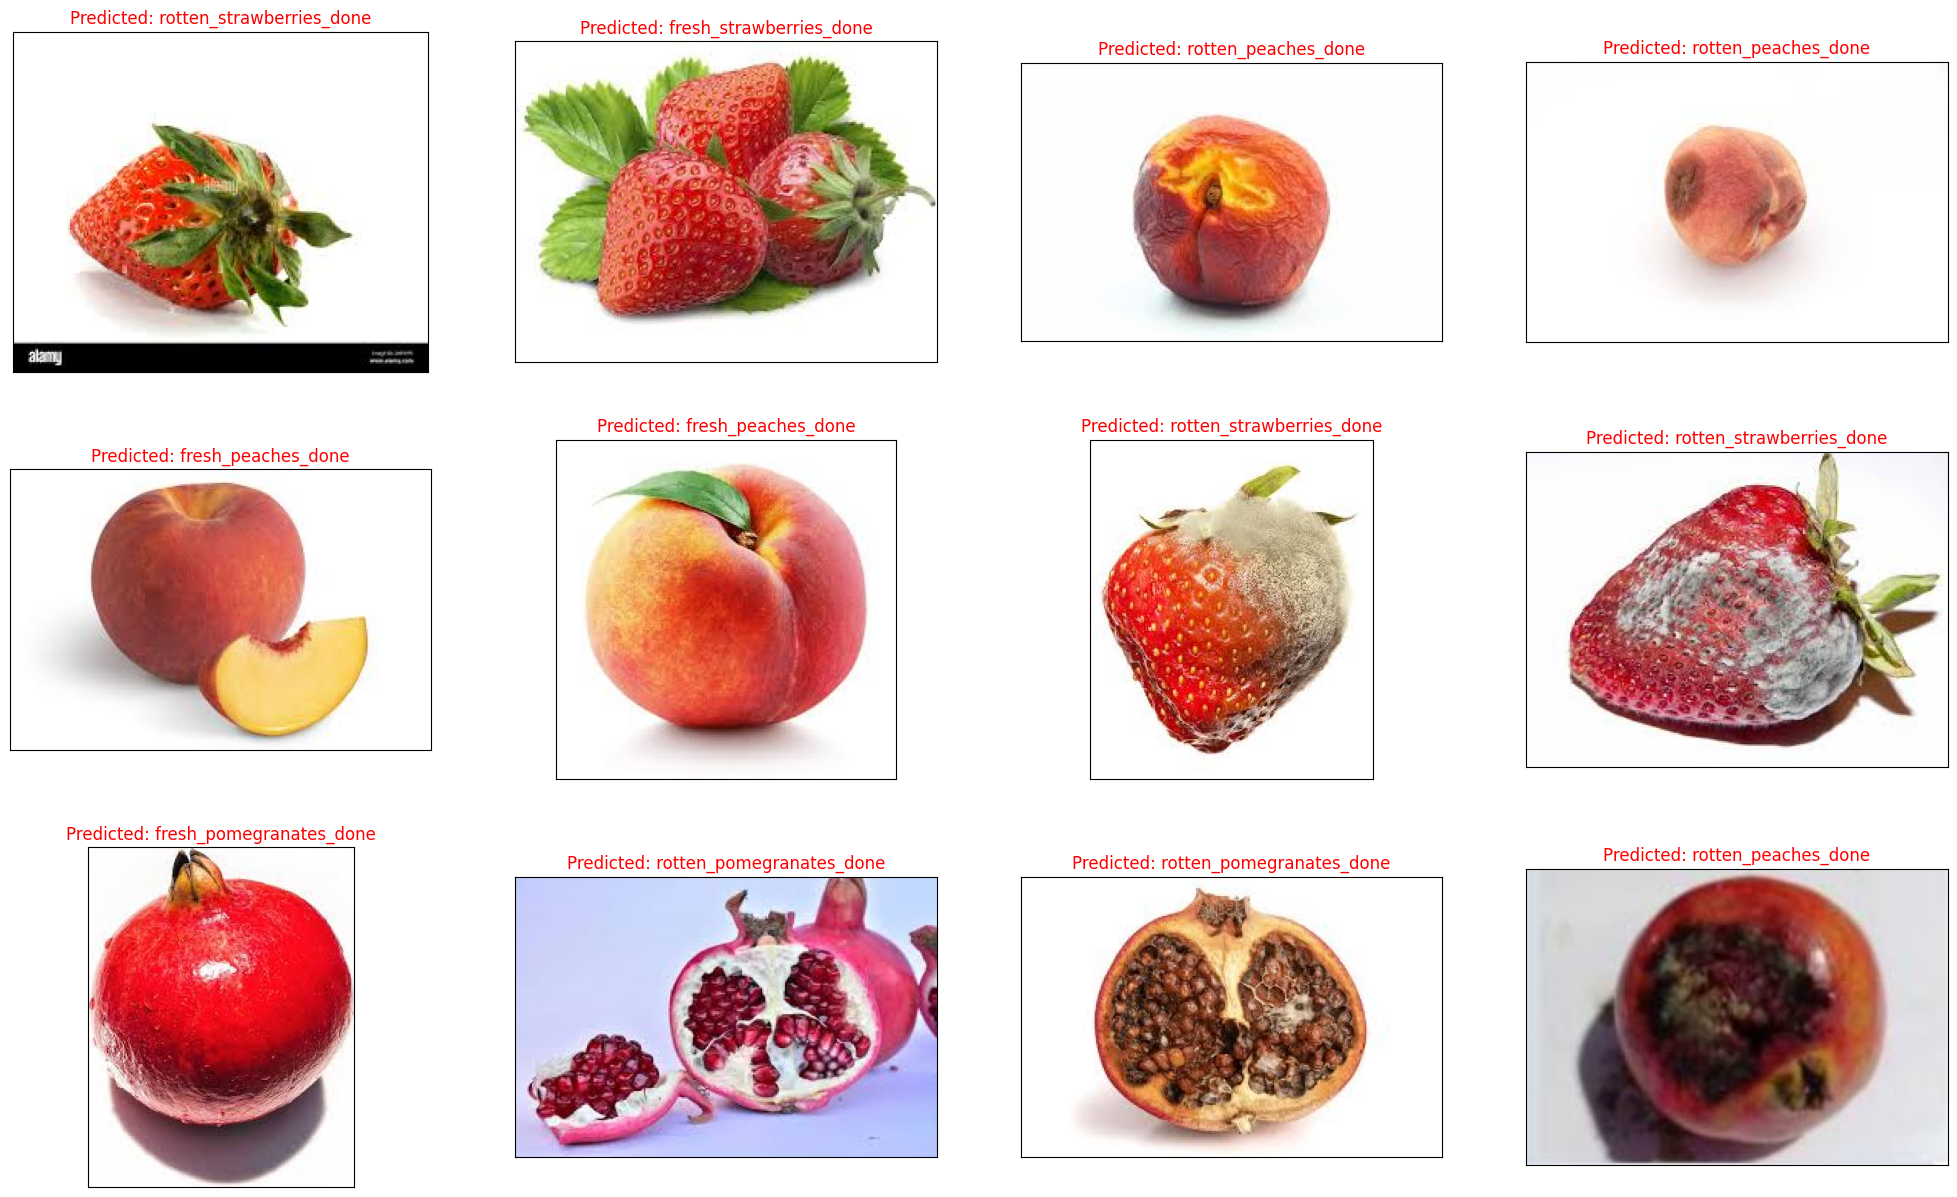

<Figure size 640x480 with 0 Axes>

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_outside_generator.filepaths[i]))
    ax.set_title(f"Predicted: {pred2[i]}", color=color)
plt.show()
plt.tight_layout()